# Problem Statement
## Use Random Forest to prepare a model on fraud data
## treating those who have taxable_income <= 30000 as "Risky" and others are "Good"

# What is a Random Forest Algorithm?
## Random forest is a Supervised Machine Learning Algorithm that is used widely in Classification and Regression problems. It builds decision trees on different samples and takes their majority vote for classification and average in case of regression.
## Random Forest is a classifier that contains a number of decision trees on various subsets of the given dataset and takes the average to improve the predictive accuracy of that dataset.
## The greater number of trees in the forest leads to higher accuracy and prevents the problem of overfitting.
## It is a graphical representation for getting all the possible solutions to a problem/decision based on given conditions.
## The random forest approach is a bagging method where deep trees, fitted on bootstrap samples, are combined to produce an output with lower variance. However, random forests also use another trick to make the multiple fitted trees a bit less correlated with each others: when growing each tree, instead of only sampling over the observations in the dataset to generate a bootstrap sample, we also sample over features and keep only a random subset of them to build the tree.
## Sampling over features has indeed the effect that all trees do not look at the exact same information to make their decisions and, so, it reduces the correlation between the different returned outputs. Another advantage of sampling over the features is that it makes the decision making process more robust to missing data
## Bagging– It creates a different training subset from sample training data with replacement & the final output is based on majority voting. For example, Random Forest.

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
sns.set_style('darkgrid')
from collections import Counter
from imblearn.over_sampling import SMOTE,  ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report,confusion_matrix,accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

C:\Users\elcot\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# importing dataset
df=pd.read_csv('Fraud_check.csv')
df

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


# About Dataset

## Undergrad : person is under graduated or not
## Marital.Status : marital status of a person
## Taxable.Income : Taxable income is the amount of how much tax an individual owes to the government
## Work Experience : Work experience of an individual person
## Urban : Whether that person belongs to urban area or not

# Data Exploration

In [5]:
df.isnull().any()

Undergrad          False
Marital.Status     False
Taxable.Income     False
City.Population    False
Work.Experience    False
Urban              False
dtype: bool

In [6]:
df.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

# Descriptive Analysis

In [7]:
df.shape

(600, 6)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [9]:
df[df.duplicated()].shape

(0, 6)

In [10]:
df[df.duplicated()]

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban


In [11]:
df.describe()

,Taxable.Income,City.Population,Work.Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


# Feature Engineering

## Lets assume: taxable_income <= 30000 as “Risky=0” and others are “Good=1”

In [12]:
df['Taxable.Income'].describe()

count      600.000000
mean     55208.375000
std      26204.827597
min      10003.000000
25%      32871.500000
50%      55074.500000
75%      78611.750000
max      99619.000000
Name: Taxable.Income, dtype: float64

In [13]:
# Converting taxable_income <= 30000 as "Risky" and others are "Good"
df1=df.copy()
df1['taxable_category'] = pd.cut(x = df1['Taxable.Income'], bins = [10002,30000,99620], labels = ['Risky', 'Good'])
df1.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,taxable_category
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good


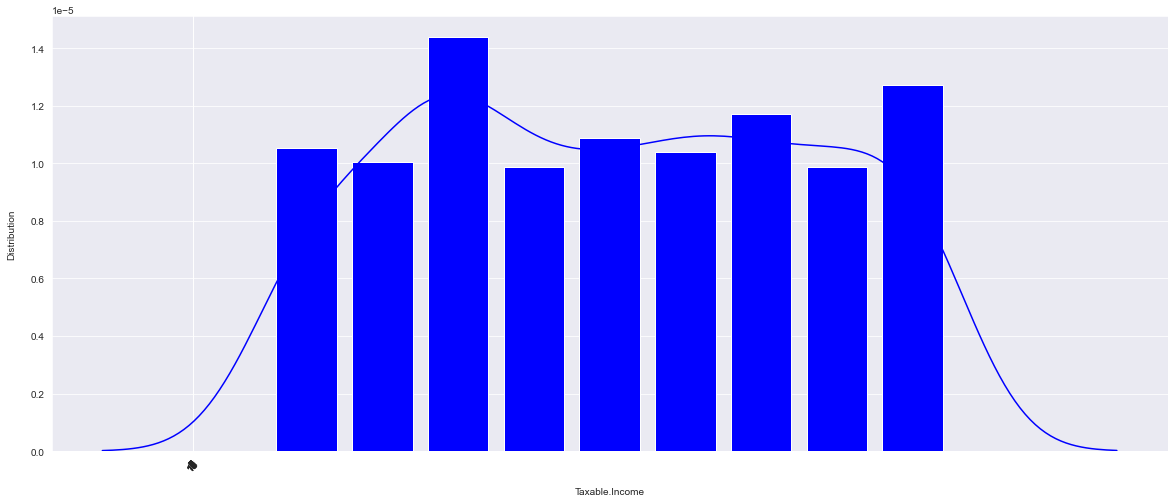

In [14]:
def distplot(param):
    plt.figure(figsize=(20,8))
    sns.distplot(df[param], color = "blue", hist_kws={"rwidth":0.80, 'alpha':1.0})
    plt.xticks(np.arange(0,20,1),rotation=45)
    plt.xlabel('\n'+param)
    plt.ylabel('Distribution\n')
    plt.show()
distplot("Taxable.Income")

In [15]:
df1.taxable_category.value_counts()

Good     476
Risky    124
Name: taxable_category, dtype: int64

In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Undergrad         600 non-null    object  
 1   Marital.Status    600 non-null    object  
 2   Taxable.Income    600 non-null    int64   
 3   City.Population   600 non-null    int64   
 4   Work.Experience   600 non-null    int64   
 5   Urban             600 non-null    object  
 6   taxable_category  600 non-null    category
dtypes: category(1), int64(3), object(3)
memory usage: 29.0+ KB


In [17]:
categorical_features = df1.describe(include=["object",'category']).columns
categorical_features

Index(['Undergrad', 'Marital.Status', 'Urban', 'taxable_category'], dtype='object')

In [18]:
numerical_features = df1.describe(include=["int64","float64"]).columns
numerical_features

Index(['Taxable.Income', 'City.Population', 'Work.Experience'], dtype='object')

# Data Visualization

## Univariate plots

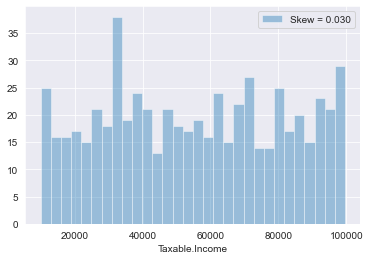

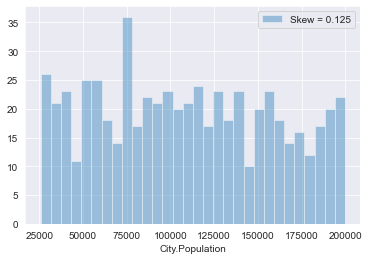

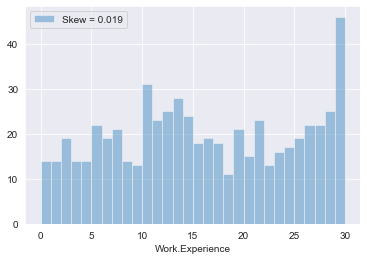

In [19]:
numerical_features=[feature for feature in df.columns if df[feature].dtypes != 'O']
for feat in numerical_features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

## numerical_features

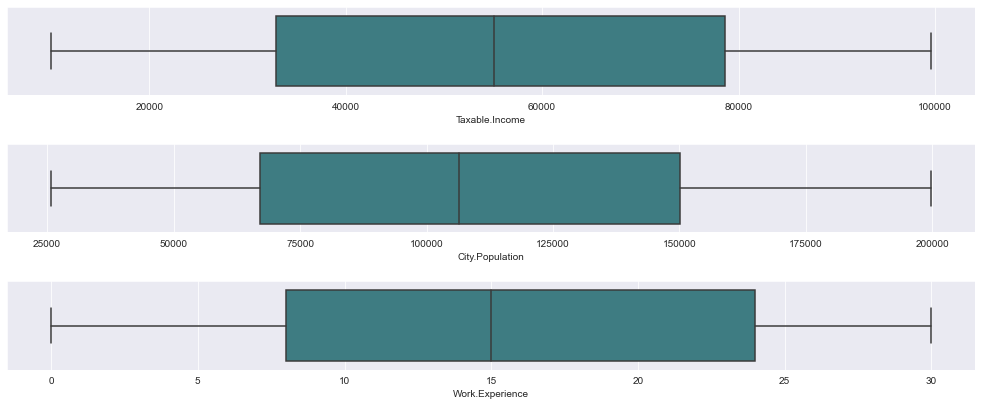

In [21]:
ot=df.copy() 
fig, axes=plt.subplots(3,1,figsize=(14,6),sharex=False,sharey=False)
sns.boxplot(x='Taxable.Income',data=ot,palette='crest',ax=axes[0])
sns.boxplot(x='City.Population',data=ot,palette='crest',ax=axes[1])
sns.boxplot(x='Work.Experience',data=ot,palette='crest',ax=axes[2])
plt.tight_layout(pad=2.0)

<AxesSubplot:>

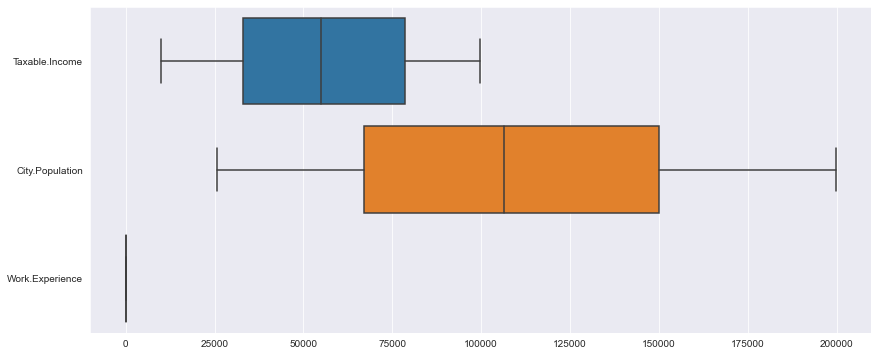

In [22]:
#outlier
plt.figure(figsize=(14,6))
sns.boxplot(data=df[numerical_features], orient="h")

## Multivariate Analysis

<Figure size 576x576 with 0 Axes>

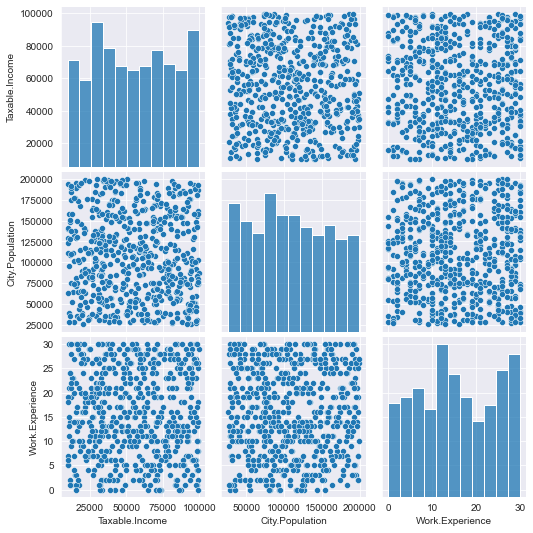

In [23]:
plt.figure(figsize=(8,8))
sns.pairplot(df, palette='coolwarm')
plt.show()

<AxesSubplot:>

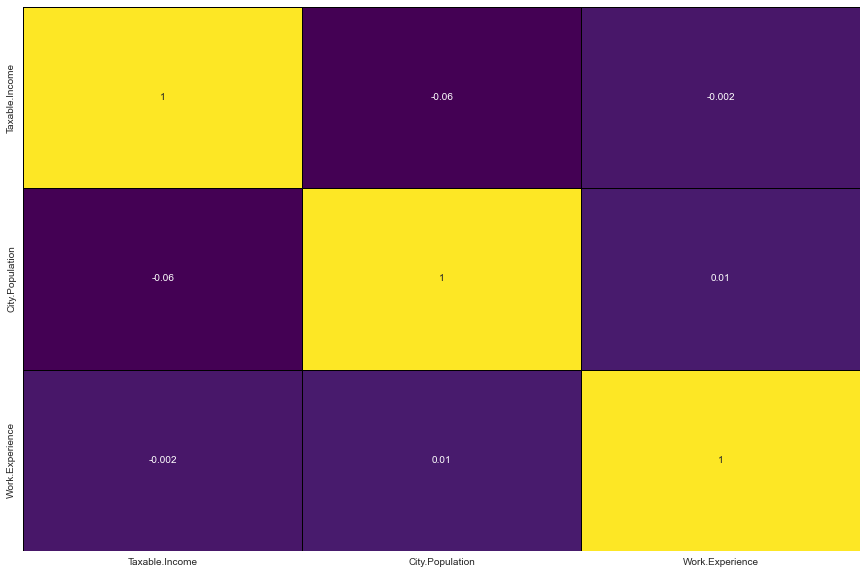

In [24]:
# Having a look at the correlation matrix

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, fmt='.1g', cmap="viridis", cbar=False, linewidths=0.5, linecolor='black')

Index(['Undergrad', 'Marital.Status', 'Urban', 'taxable_category'], dtype='object')


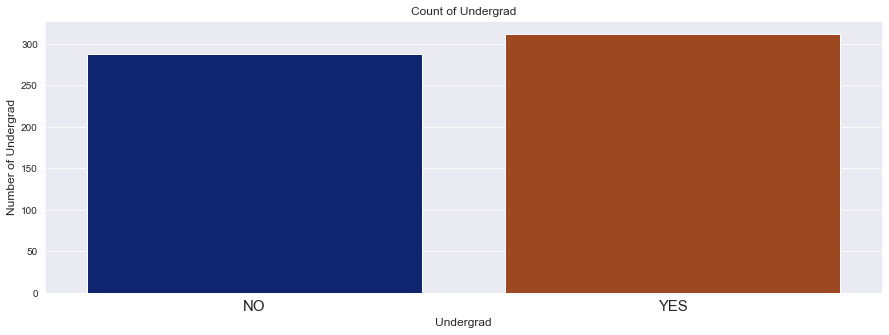

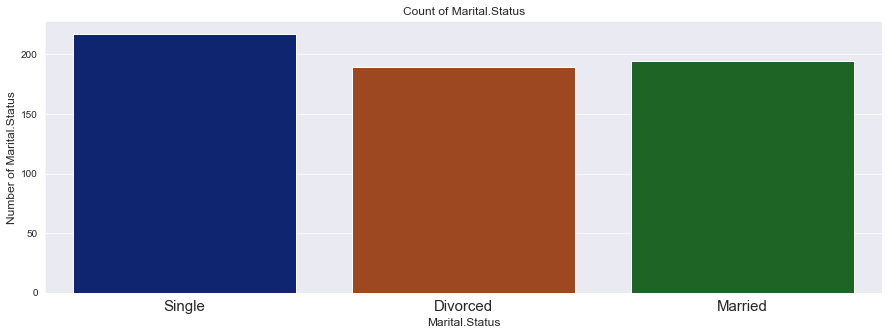

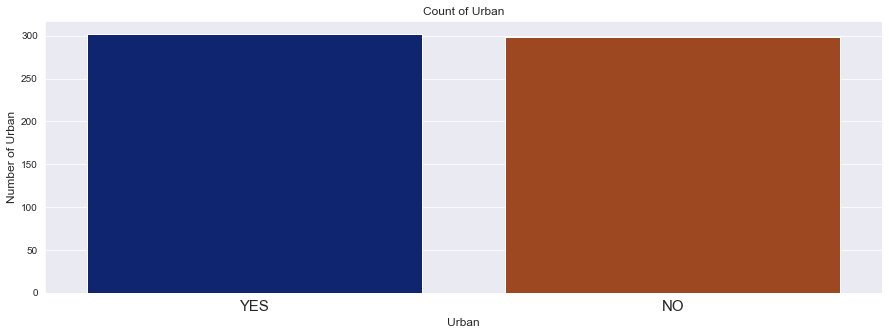

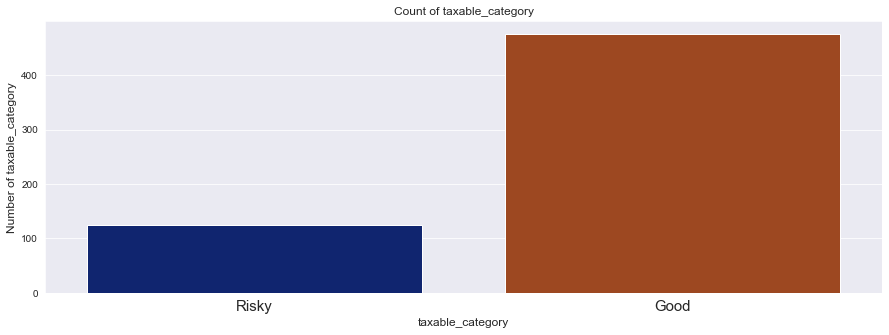

In [25]:
print(categorical_features)

for idx, column in enumerate(categorical_features):
    plt.figure(figsize=(15, 5))
    unique = df1[column].value_counts(ascending=True);
 
    #plt.subplot(1, len(categorical_features), idx+1)    
    plt.title("Count of "+ column)
    sns.countplot(data=df1, x=column,palette = "dark")
    #plt.bar(unique.index, unique.values);
    plt.xticks(rotation = 0, size = 15)
    
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Number of "+ column, fontsize=12)

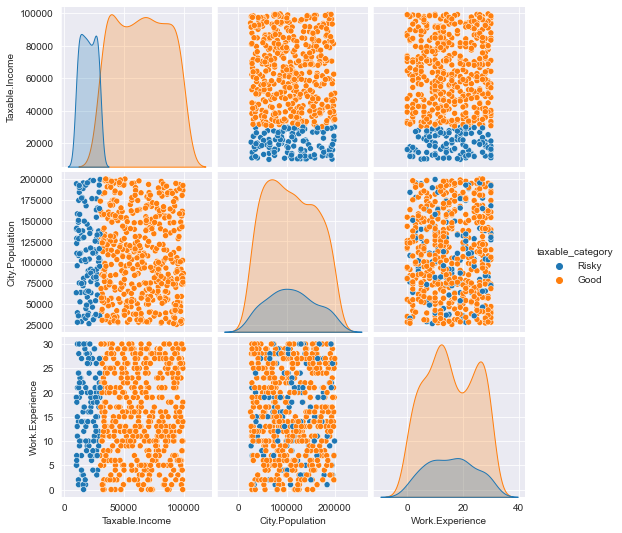

In [26]:
# let's plot pair plot to visualise the attributes all at once
import seaborn as sns
sns.pairplot(data=df1, hue = 'taxable_category')

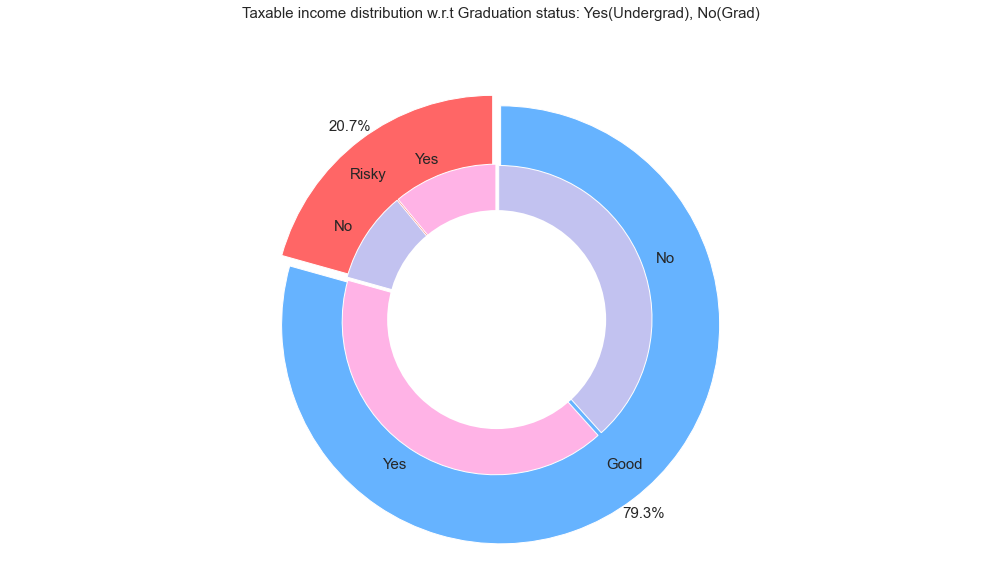

In [27]:
plt.figure(figsize=(14, 8))
labels =["Risky", "Good"]
values = [df1["taxable_category"][df1["taxable_category"] == 'Risky'].groupby(by = df1.Undergrad).count().sum(),
         df1["taxable_category"][df1["taxable_category"] == 'Good'].groupby(by = df1.Undergrad).count().sum()]
labels_gender = ["Yes","No","Yes","No"]
sizes_gender = [66,58 , 246,230]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#ffb3e6', '#c2c2f0']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution w.r.t Graduation status: Yes(Undergrad), No(Grad)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

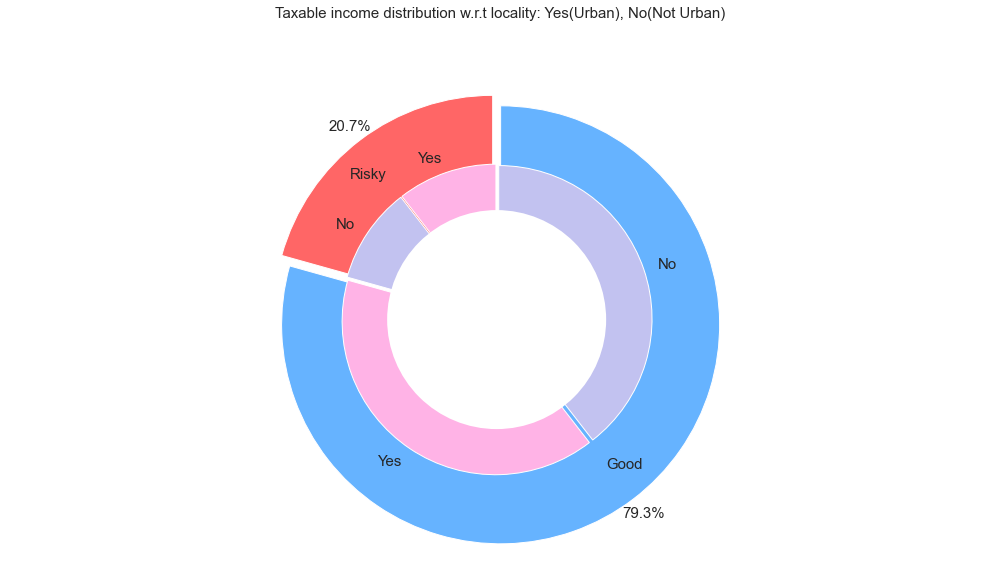

In [28]:
plt.figure(figsize=(14, 8))
labels =["Risky", "Good"]
values = [df1["taxable_category"][df1["taxable_category"] == 'Risky'].groupby(by = df1.Urban).count().sum(),
         df1["taxable_category"][df1["taxable_category"] == 'Good'].groupby(by = df1.Urban).count().sum()]
labels_gender = ["Yes","No","Yes","No"]
sizes_gender = [63,61 , 239,237]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#ffb3e6', '#c2c2f0']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution w.r.t locality: Yes(Urban), No(Not Urban)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

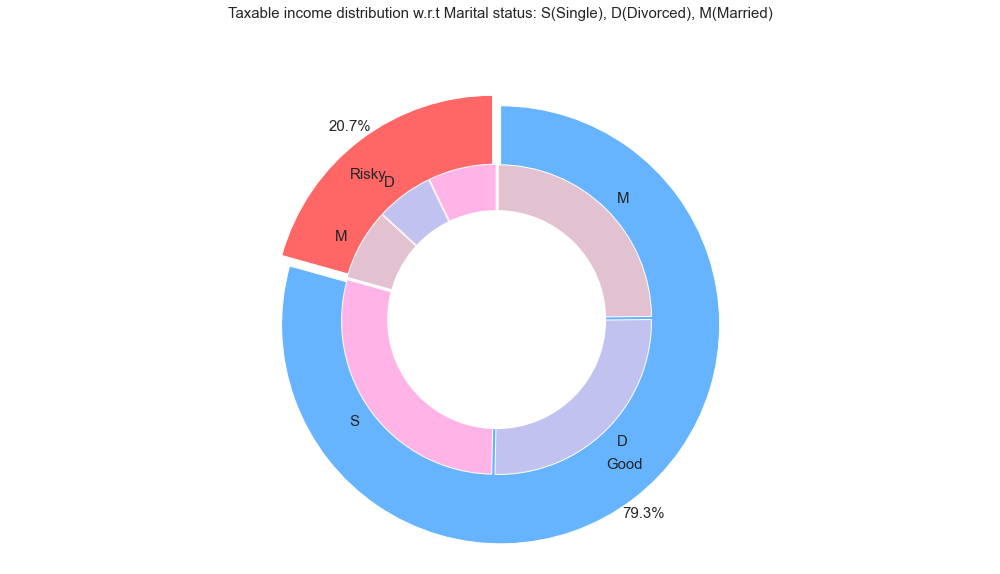

In [29]:
plt.figure(figsize=(14, 8))
labels =["Risky", "Good"]
values = [df1["taxable_category"][df1["taxable_category"] == 'Risky'].groupby(by = df1["Marital.Status"]).count().sum(),
         df1["taxable_category"][df1["taxable_category"] == 'Good'].groupby(by = df1["Marital.Status"]).count().sum()]
labels_gender = ["","D","M","S","D", "M"]
sizes_gender = [43,36,45,174,153,149]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#e2c2d0','#ffb3e6', '#c2c2f0', '#e2c2d0']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution w.r.t Marital status: S(Single), D(Divorced), M(Married)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

In [30]:
data_ = df1.copy()
data_.drop('Taxable.Income',axis=1, inplace =True)
data_ = pd.get_dummies(data_.iloc[:,:-1])
data_.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES
0,50047,10,1,0,0,0,1,0,1
1,134075,18,0,1,1,0,0,0,1
2,160205,30,1,0,0,1,0,0,1
3,193264,15,0,1,0,0,1,0,1
4,27533,28,1,0,0,1,0,1,0


Text(0.5, 1.0, 'Correlation with Sales \n')

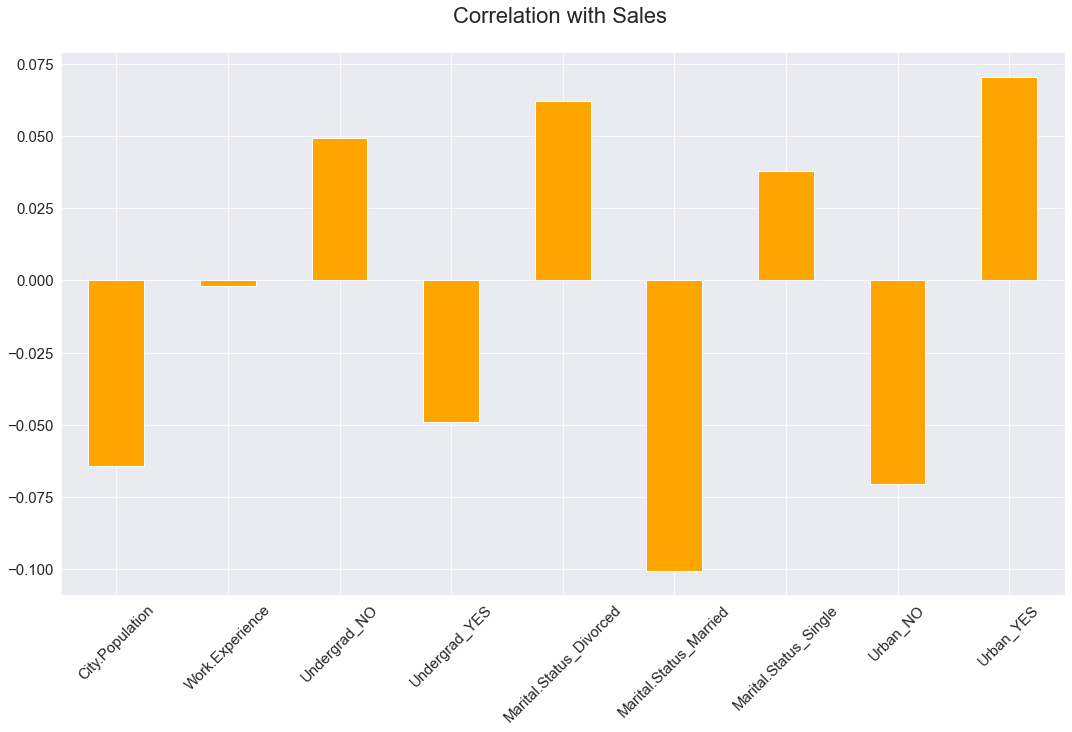

In [31]:
data2 = data_.copy()

correlations = data2.corrwith(df1['Taxable.Income'])
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        color = 'orange',
        rot = 45, grid = True)
plt.title('Correlation with Sales \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

## Checking for Imbalanced or balanced dataset with regards to the Target

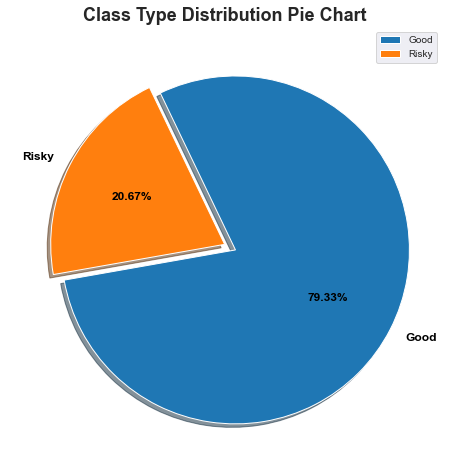

In [32]:
plt.figure(figsize = (12,8))
plt.pie(df1['taxable_category'].value_counts(),
       labels=df1.taxable_category.unique(),
       explode = [0.07,0.0],
       autopct= '%.2f%%',
       shadow= True,
       startangle= 190,
       textprops = {'size':'large',
                   'fontweight':'bold',
                    'rotation':'0',
                   'color':'black'})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 18, fontweight = 'bold')
plt.show()

In [33]:
countNotermdeposit = len(df1[df1['taxable_category'] == 'Good'])
counthavetermdeposit = len(df1[df1['taxable_category'] == 'Risky'])
print("Percentage of Customer doesn't have a term deposit: {:.2f}%".format((countNotermdeposit / (len(df1.taxable_category))*100)))
print("Percentage of Customer have a term deposit: {:.2f}%".format((counthavetermdeposit / (len(df1.taxable_category))*100)))

Percentage of Customer doesn't have a term deposit: 79.33%
Percentage of Customer have a term deposit: 20.67%


In [34]:
df1.taxable_category.value_counts()

Good     476
Risky    124
Name: taxable_category, dtype: int64

Text(0.5, 1.0, 'Risky or Good for Individual Taxable Income ')

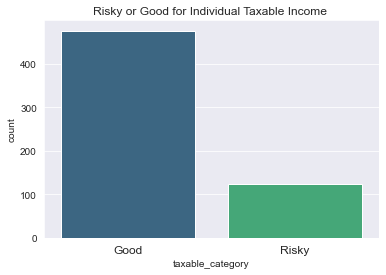

In [35]:
sns.countplot(x='taxable_category', data=df1, palette = 'viridis', 
              order=df1['taxable_category'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Risky or Good for Individual Taxable Income ')

# Feature Selection Technique

## Data Pre-Processing

In [36]:
model_data = df1.copy()
model_data.rename(columns={'Marital.Status':'Marital_Status', 'Taxable.Income':'Taxable_Income','Work.Experience':'Work_Experience','City.Population':'City_Population'}, inplace = True)
model_data.drop('Taxable_Income', axis=1, inplace = True)
categorical_features = model_data.describe(include=["object",'category']).columns
categorical_features

Index(['Undergrad', 'Marital_Status', 'Urban', 'taxable_category'], dtype='object')

In [37]:
#Creating dummy vairables of the categorical features
le = LabelEncoder()
for col in categorical_features:
        le.fit(model_data[col])
        model_data[col] = le.transform(model_data[col])
model_data.head()

,Undergrad,Marital_Status,City_Population,Work_Experience,Urban,taxable_category
0,0,2,50047,10,1,0
1,1,0,134075,18,1,0
2,0,1,160205,30,1,0
3,1,2,193264,15,1,0
4,0,1,27533,28,0,0


# Data Pre-processing for feature Selection

In [38]:
data_ = df1.copy()
data_.drop('Taxable.Income',axis=1, inplace =True)
data_ = pd.get_dummies(data_.iloc[:,:-1])
data_.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES
0,50047,10,1,0,0,0,1,0,1
1,134075,18,0,1,1,0,0,0,1
2,160205,30,1,0,0,1,0,0,1
3,193264,15,0,1,0,0,1,0,1
4,27533,28,1,0,0,1,0,1,0


In [39]:
data_['Taxable_Income'] = df1.taxable_category
data_.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,1,0,0,0,1,0,1,Good
1,134075,18,0,1,1,0,0,0,1,Good
2,160205,30,1,0,0,1,0,0,1,Good
3,193264,15,0,1,0,0,1,0,1,Good
4,27533,28,1,0,0,1,0,1,0,Good


In [40]:
le = LabelEncoder()
le.fit(data_["Taxable_Income"])
data_["Taxable_Income"]=le.transform(data_["Taxable_Income"])
data_.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,1,0,0,0,1,0,1,0
1,134075,18,0,1,1,0,0,0,1,0
2,160205,30,1,0,0,1,0,0,1,0
3,193264,15,0,1,0,0,1,0,1,0
4,27533,28,1,0,0,1,0,1,0,0


In [41]:
# split into input (X) and output (y) variables
X = data_.iloc[:, :-1]

y=  data_.Taxable_Income

In [42]:
#Feature importance
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest, chi2

In [43]:
# feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, y)

In [44]:
# summarize scores
scores = fit.scores_

features = fit.transform(X)

In [45]:
score_df = pd.DataFrame(list(zip(scores, X.columns)),
               columns =['Score', 'Feature'])
score_df.sort_values(by="Score", ascending=False, inplace=True)
score_df

,Score,Feature
0,2045.643886,City.Population
5,0.756912,Marital.Status_Married
4,0.302172,Marital.Status_Divorced
6,0.095850,Marital.Status_Single
2,0.048929,Undergrad_NO
3,0.045165,Undergrad_YES
1,0.011709,Work.Experience
7,0.007044,Urban_NO
8,0.006951,Urban_YES


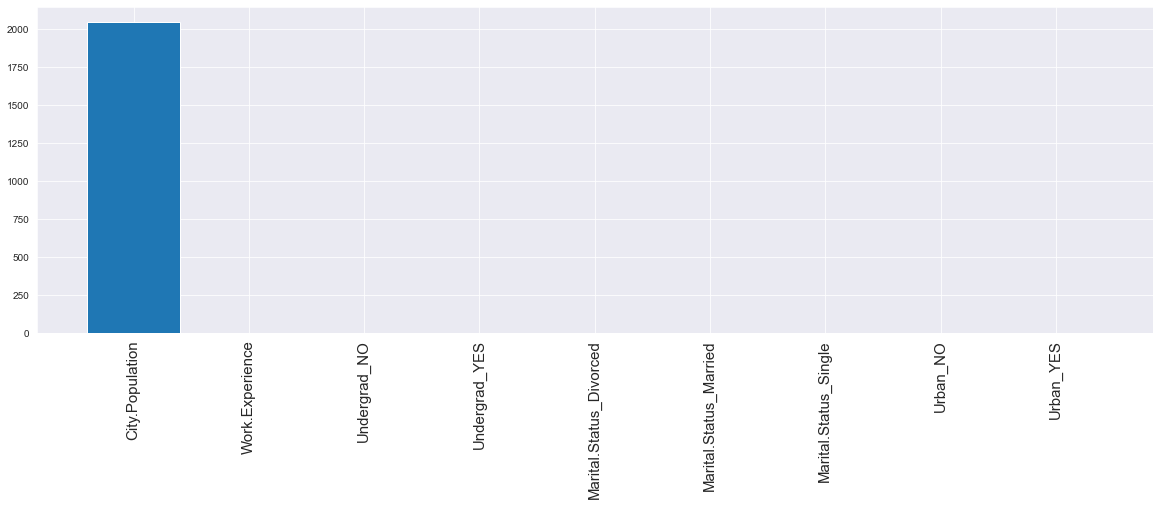

In [46]:
fig, axes = plt.subplots(figsize=(20, 6))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8])
axes.set_xticklabels(X.columns.values)
plt.xticks(rotation = 90, size = 15)
plt.show()

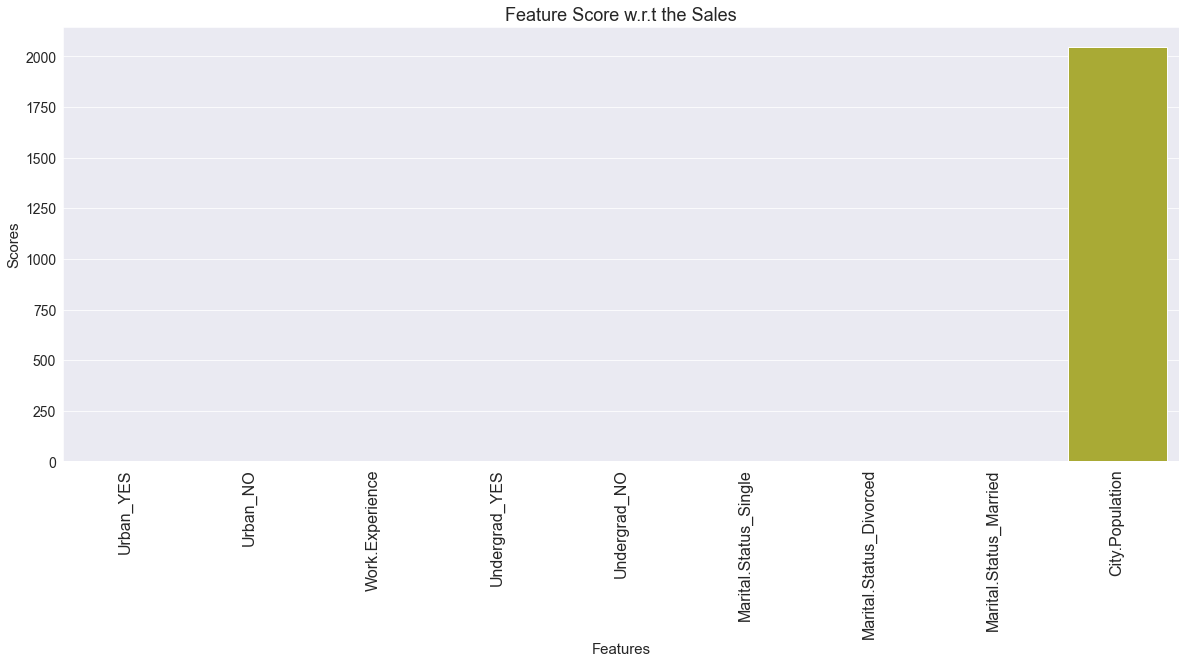

In [47]:
plt.figure(figsize=(20,8))
# make barplot and sort bars
sns.barplot(x='Feature',
            y="Score", 
            data=score_df, 
            order=score_df.sort_values('Score').Feature)
# set labels
plt.xlabel("Features", size=15)
plt.ylabel("Scores", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Score w.r.t the Sales", size=18)
plt.show()

# Random Forest Built-in Feature Importance
## The Random Forest algorithm has built-in feature importance which can be computed in two ways:

## Gini importance (or mean decrease impurity), which is computed from the Random Forest structure. Let’s look how the Random Forest is constructed. It is a set of Decision Trees. Each Decision Tree is a set of internal nodes and leaves. In the internal node, the selected feature is used to make decision how to divide the data set into two separate sets with similars responses within. The features for internal nodes are selected with some criterion, which for classification tasks can be gini impurity or infomation gain, and for regression is variance reduction. We can measure how each feature decrease the impurity of the split (the feature with highest decrease is selected for internal node). For each feature we can collect how on average it decreases the impurity. The average over all trees in the forest is the measure of the feature importance. This method is available in scikit-learn implementation of the Random Forest (for both classifier and regressor). It is worth to mention, that in this method we should look at relative values of the computed importances. This biggest advantage of this method is a speed of computation - all needed values are computed during the Radom Forest training. The drawbacks of the method is to tendency to prefer (select as important) numerical features and categorical features with high cardinality. What is more, in the case of correlated features it can select one of the feature and neglect the importance of the second one (which can lead to wrong conclusions).

## Mean Decrease Accuracy - is a method of computing the feature importance on permuted out-of-bag (OOB) samples based on mean decrease in the accuracy. This method is not implemented in the scikit-learn package. The very similar to this method is permutation based importance described below in this post.

In [48]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,n_estimators=100, oob_score=True)

classifier_rf.fit(X, y)

# checking the oob score
print('checking the oob score',classifier_rf.oob_score_)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}
from sklearn.model_selection import GridSearchCV
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X, y)

print('Best Score',grid_search.best_score_)

rf_best = grid_search.best_estimator_
print(rf_best)

checking the oob score 0.7933333333333333
Fitting 4 folds for each of 180 candidates, totalling 720 fits
Best Score 0.7933333333333333
RandomForestClassifier(max_depth=2, min_samples_leaf=5, n_estimators=10,
                       n_jobs=-1, random_state=42)


## Now let’s sort the data with the help of feature importance

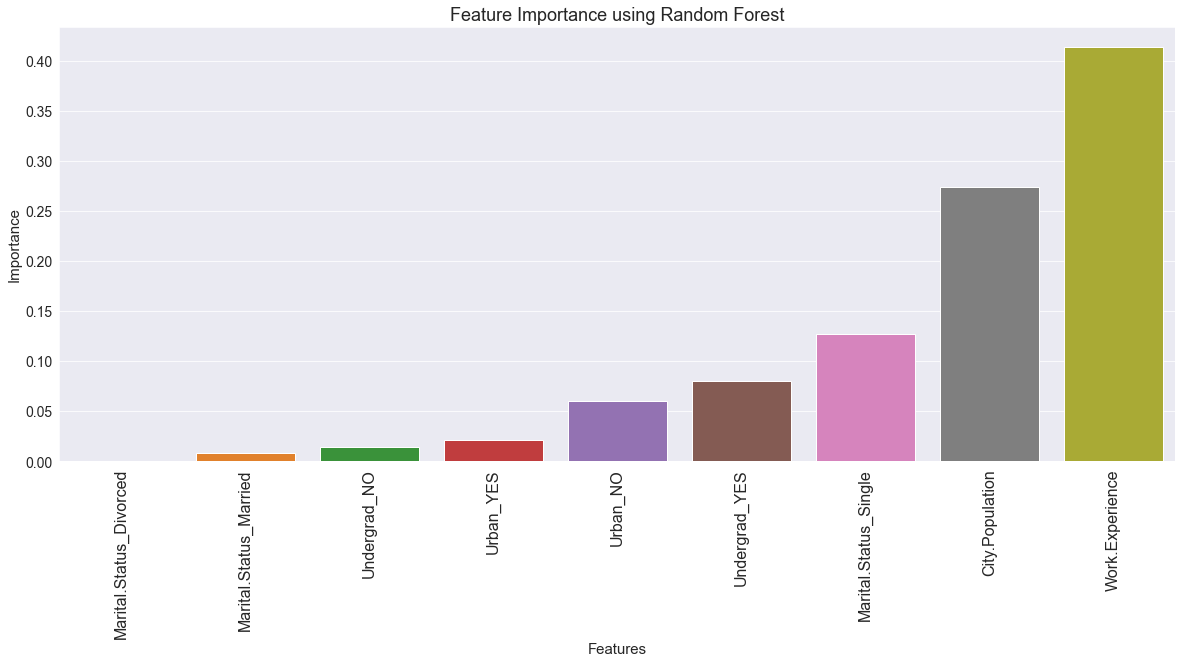

In [49]:
rf_best.feature_importances_
imp_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_best.feature_importances_
})

plt.figure(figsize=(20,8))
# make barplot and sort bars
sns.barplot(x='Feature',
            y="Importance", 
            data=imp_df, 
            order=imp_df.sort_values('Importance').Feature)
# set labels
plt.xlabel("Features", size=15)
plt.ylabel("Importance", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Importance using Random Forest", size=18)
plt.show()

# Test Train Split With Imbalanced Dataset

In [50]:
model_data.columns

Index(['Undergrad', 'Marital_Status', 'City_Population', 'Work_Experience',
       'Urban', 'taxable_category'],
      dtype='object')

In [51]:
x = model_data.drop('taxable_category',axis=1)
y = model_data['taxable_category']

In [52]:
y.unique()

array([0, 1])

In [53]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in skf.split(x, y):
# select rows
    train_X, test_X = x.iloc[train_ix], x.loc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
# summarize train and test composition
counter_train = Counter(train_y)
counter_test = Counter(test_y)
print('Training Data',counter_train,'Testing Data',counter_test)

Training Data Counter({0: 429, 1: 111}) Testing Data Counter({0: 47, 1: 13})


In [54]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0,stratify=y)

In [55]:
# summarize train and test composition
counter_train = Counter(y_train)
counter_test = Counter(y_test)
print('Training Data',counter_train,'Testing Data',counter_test)

Training Data Counter({0: 333, 1: 87}) Testing Data Counter({0: 143, 1: 37})


In [56]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (420, 5)
Shape of X_test:  (180, 5)
Shape of y_train:  (420,)
Shape of y_test (180,)


# Grid search using Stratified Kfold Splits on Imbalanced Dataset

In [57]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [58]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(train_X, train_y)

print_score(rf_clf, train_X, train_y, test_X, test_y, train=True)
print_score(rf_clf, train_X, train_y, test_X, test_y, train=False)

Train Result:
Accuracy Score: 99.81%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.997674    1.000000  0.998148    0.998837      0.998152
recall       1.000000    0.990991  0.998148    0.995495      0.998148
f1-score     0.998836    0.995475  0.998148    0.997155      0.998145
support    429.000000  111.000000  0.998148  540.000000    540.000000
_______________________________________________
Confusion Matrix: 
 [[429   0]
 [  1 110]]

Test Result:
Accuracy Score: 73.33%
_______________________________________________
CLASSIFICATION REPORT:
                   0     1  accuracy  macro avg  weighted avg
precision   0.771930   0.0  0.733333   0.385965      0.604678
recall      0.936170   0.0  0.733333   0.468085      0.733333
f1-score    0.846154   0.0  0.733333   0.423077      0.662821
support    47.000000  13.0  0.733333  60.000000     60.000000
_________________________________

# Grid search using Train Test Splits Stratifying Target feature on Imbalanced Dataset

In [59]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(x_train, y_train)

print_score(rf_clf, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf, x_train, y_train, x_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0     1  accuracy  macro avg  weighted avg
precision    1.0   1.0       1.0        1.0           1.0
recall       1.0   1.0       1.0        1.0           1.0
f1-score     1.0   1.0       1.0        1.0           1.0
support    333.0  87.0       1.0      420.0         420.0
_______________________________________________
Confusion Matrix: 
 [[333   0]
 [  0  87]]

Test Result:
Accuracy Score: 73.89%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.785714   0.083333  0.738889    0.434524      0.641336
recall       0.923077   0.027027  0.738889    0.475052      0.738889
f1-score     0.848875   0.040816  0.738889    0.444845      0.682774
support    143.000000  37.000000  0.738889  180.000000    180.000000
_______________________________________________
Confusion

# Observation:
In both the condition, due to imbalanced dataset our results are getting biased towards the majority. The model is correctly classifying all the majority classes yet fails to classify the minority classes. Hence, we need to use some kind of oversampling techniques to balance the dataset.

# Handling imbalance data using SMOTE based techniques

In [60]:
x = model_data.drop(['taxable_category'], axis=1)
y = model_data['taxable_category']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.30, random_state=0,stratify=y)

In [61]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (420, 5)
Shape of X_test:  (180, 5)
Shape of y_train:  (420,)
Shape of y_test (180,)


# SMOTE Oversampling technique

In [62]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
x_train_sm, y_train_sm = smt.fit_resample(x_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 333})


# ADASYN: Adaptive Synthetic Sampling Approach

In [63]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using ADASYN
ada = ADASYN(random_state=130)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 327})


# Hybridization: SMOTE + Tomek Links

In [64]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=139)
x_train_smtom, y_train_smtom = smtom.fit_resample(x_train, y_train)

counter = Counter(y_train_smtom)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 239, 1: 239})


# Hybridization: SMOTE + ENN

In [65]:
counter = Counter(y_train)
print('Before',counter)
#oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN()
x_train_smenn, y_train_smenn = smenn.fit_resample(x_train, y_train)

counter = Counter(y_train_smenn)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({1: 84, 0: 79})


# Performance Analysis after Resampling

In [66]:
sampled_data = {
    'ACTUAL':[x_train, y_train],
    'SMOTE':[x_train_sm, y_train_sm],
    'ADASYN':[x_train_ada, y_train_ada],
    'SMOTE_TOMEK':[x_train_smtom, y_train_smtom],
    'SMOTE_ENN':[x_train_smenn, y_train_smenn]
}

In [67]:
def test_eval(clf_model, X_test, y_test, algo=None, sampling=None):
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test)
    y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    #plot_confusion_matrix(clf_model, X_test, y_test)  
    #plt.show() 
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    #print('AUC-ROC')
    #print('='*60)
    #print(roc_auc_score(y_test, y_prob[:,1], multi_class='ovo'))
    
    #x = roc_auc_score(y_test, y_prob[:,1])
    f1 = f1_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    precision = precision_score(y_test, y_pred, average='micro')
          
    
    return algo,precision,recall,f1,sampling

In [68]:
model_params = {

    'random-forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
             "n_estimators": [5, 10, 15, 20, 25], 
             'max_depth': [i for i in range(5,16,2)],
             'min_samples_split': [2, 5, 10, 15, 20, 50, 100],
             'min_samples_leaf': [1, 2, 5],
             'criterion': ['gini', 'entropy'],
             'max_features': ['log2', 'sqrt', 'auto']

         }
    }
}

In [69]:
cv = StratifiedKFold(n_splits=10, random_state=100, shuffle=True)
output = []
for model , model_hp in model_params.items():
    for resam , data in sampled_data.items():
        clf = RandomizedSearchCV(model_hp['model'], model_hp['params'],cv = cv, scoring='roc_auc', n_jobs=-1 )
        clf.fit(data[0], data[1])
        clf_best = clf.best_estimator_
        print('x'*60)
        print(model+' with ' + resam)
        print('='*60)
        output.append(test_eval(clf_best, x_test, y_test, model, resam))

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
random-forest with ACTUAL
Confusion Matrix
[[143   0]
 [ 37   0]] 

Classification Report
              precision    recall  f1-score   support

           0       0.79      1.00      0.89       143
           1       0.00      0.00      0.00        37

    accuracy                           0.79       180
   macro avg       0.40      0.50      0.44       180
weighted avg       0.63      0.79      0.70       180
 

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
random-forest with SMOTE
Confusion Matrix
[[104  39]
 [ 24  13]] 

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       143
           1       0.25      0.35      0.29        37

    accuracy                           0.65       180
   macro avg       0.53      0.54      0.53       180
weighted avg       0.70      0.65      0.67       180
 

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

# As the results can be compared, ADASYN technique gave the best results we are going to use it further

In [70]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using ADASYN
ada = ADASYN(random_state=130)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 327})


In [71]:
x_train,x_test,y_train,y_test = train_test_split(x_train_ada,y_train_ada,test_size=0.3,random_state=0, stratify=y_train_ada)

counter = Counter(y_train)
print('Train',counter)
counter = Counter(y_test)
print('Test',counter)
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Train Counter({0: 233, 1: 229})
Test Counter({0: 100, 1: 98})
Shape of X_train:  (462, 5)
Shape of X_test:  (198, 5)
Shape of y_train:  (462,)
Shape of y_test (198,)


# Random Forest

## Random Forest hyperparameter tuning

In [72]:
#base model
score_array = []
for each in range(1,200):
    rf_loop = RandomForestClassifier(n_estimators = each, random_state = 1) 
    rf_loop.fit(x_train,y_train)
    score_array.append(rf_loop.score(x_test,y_test))

In [73]:
loc = np.array(score_array).max()
score_array.index(loc)+1

44

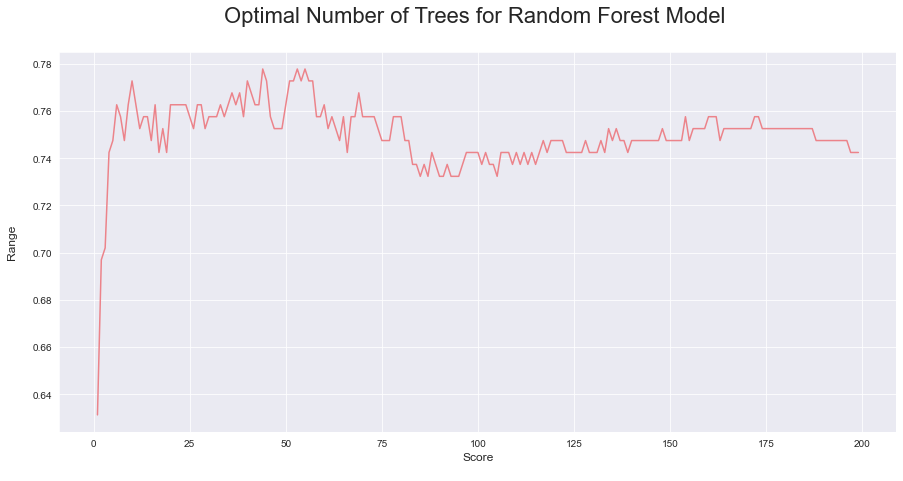

In [74]:
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,200),score_array, color = '#ec838a')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

#  Randomized Search Cross Validation

In [75]:
n_estimators = [int(x) for x in np.linspace(start=0, stop=200, num=200)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = RandomizedSearchCV(estimator=rf_clf, scoring='f1',param_distributions=random_grid, n_iter=100, cv=3, 
                               verbose=2, random_state=42, n_jobs=-1)

rf_cv.fit(x_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(x_train, y_train)

print_score(rf_clf, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best paramters: {'n_estimators': 60, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True})
Train Result:
Accuracy Score: 91.99%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.926087    0.913793  0.919913    0.919940      0.919993
recall       0.914163    0.925764  0.919913    0.919964      0.919913
f1-score     0.920086    0.919740  0.919913    0.919913      0.919915
support    233.000000  229.000000  0.919913  462.000000    462.000000
_______________________________________________
Confusion Matrix: 
 [[213  20]
 [ 17 212]]

Test Result:
Accuracy Score: 71.72%
_______________________________________________
CLASSIFICATION REPORT:
                0          1  accuracy   macro avg  weighted avg
precision    0.72   0.714286  0.717172    0.717143      0.717172
recal

## Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define

#  Grid Search Cross Validation

In [76]:
# Create a pipeline with a Random forest classifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, StandardScaler)
from time import time
    
pipe_rfc = Pipeline([ 
                      ('scl', StandardScaler()), 
                    ('rfc', RandomForestClassifier(random_state=0, n_jobs=-1) )])

# Set the grid parameters
param_grid_rfc =  [ {
    'rfc__n_estimators': [100, 200,300,400], # number of estimators
    #'rfc__criterion': ['gini', 'entropy'],   # Splitting criterion
    'rfc__max_features':[0.05 , 0.1], # maximum features used at each split
    'rfc__max_depth': [None, 5], # Max depth of the trees
    'rfc__min_samples_split': [0.005, 0.01], # mininal samples in leafs
    }]
# Use 10 fold CV
kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state= 0)
grid_rfc = GridSearchCV(pipe_rfc, param_grid= param_grid_rfc, cv=kfold, scoring='f1', verbose= 1, n_jobs=-1)

#Fit the pipeline
start = time()
grid_rfc = grid_rfc.fit(x_train, y_train)
end = time()

print("RFC grid search took %.3f seconds" %(end-start))

# Best score and best parameters
print('-------Best score----------')
print(grid_rfc.best_score_ * 100.0)
print('-------Best params----------')
print(grid_rfc.best_params_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
RFC grid search took 166.610 seconds
-------Best score----------
70.38844506088265
-------Best params----------
{'rfc__max_depth': None, 'rfc__max_features': 0.05, 'rfc__min_samples_split': 0.005, 'rfc__n_estimators': 400}


# Visualizing one of the decision tree in random forest

In [77]:
rf_best = rf_cv.best_estimator_
rf_best

RandomForestClassifier(max_depth=10, max_features='auto', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=60, random_state=42)

In [78]:
df1.taxable_category.unique()

['Good', 'Risky']
Categories (2, object): ['Risky' < 'Good']

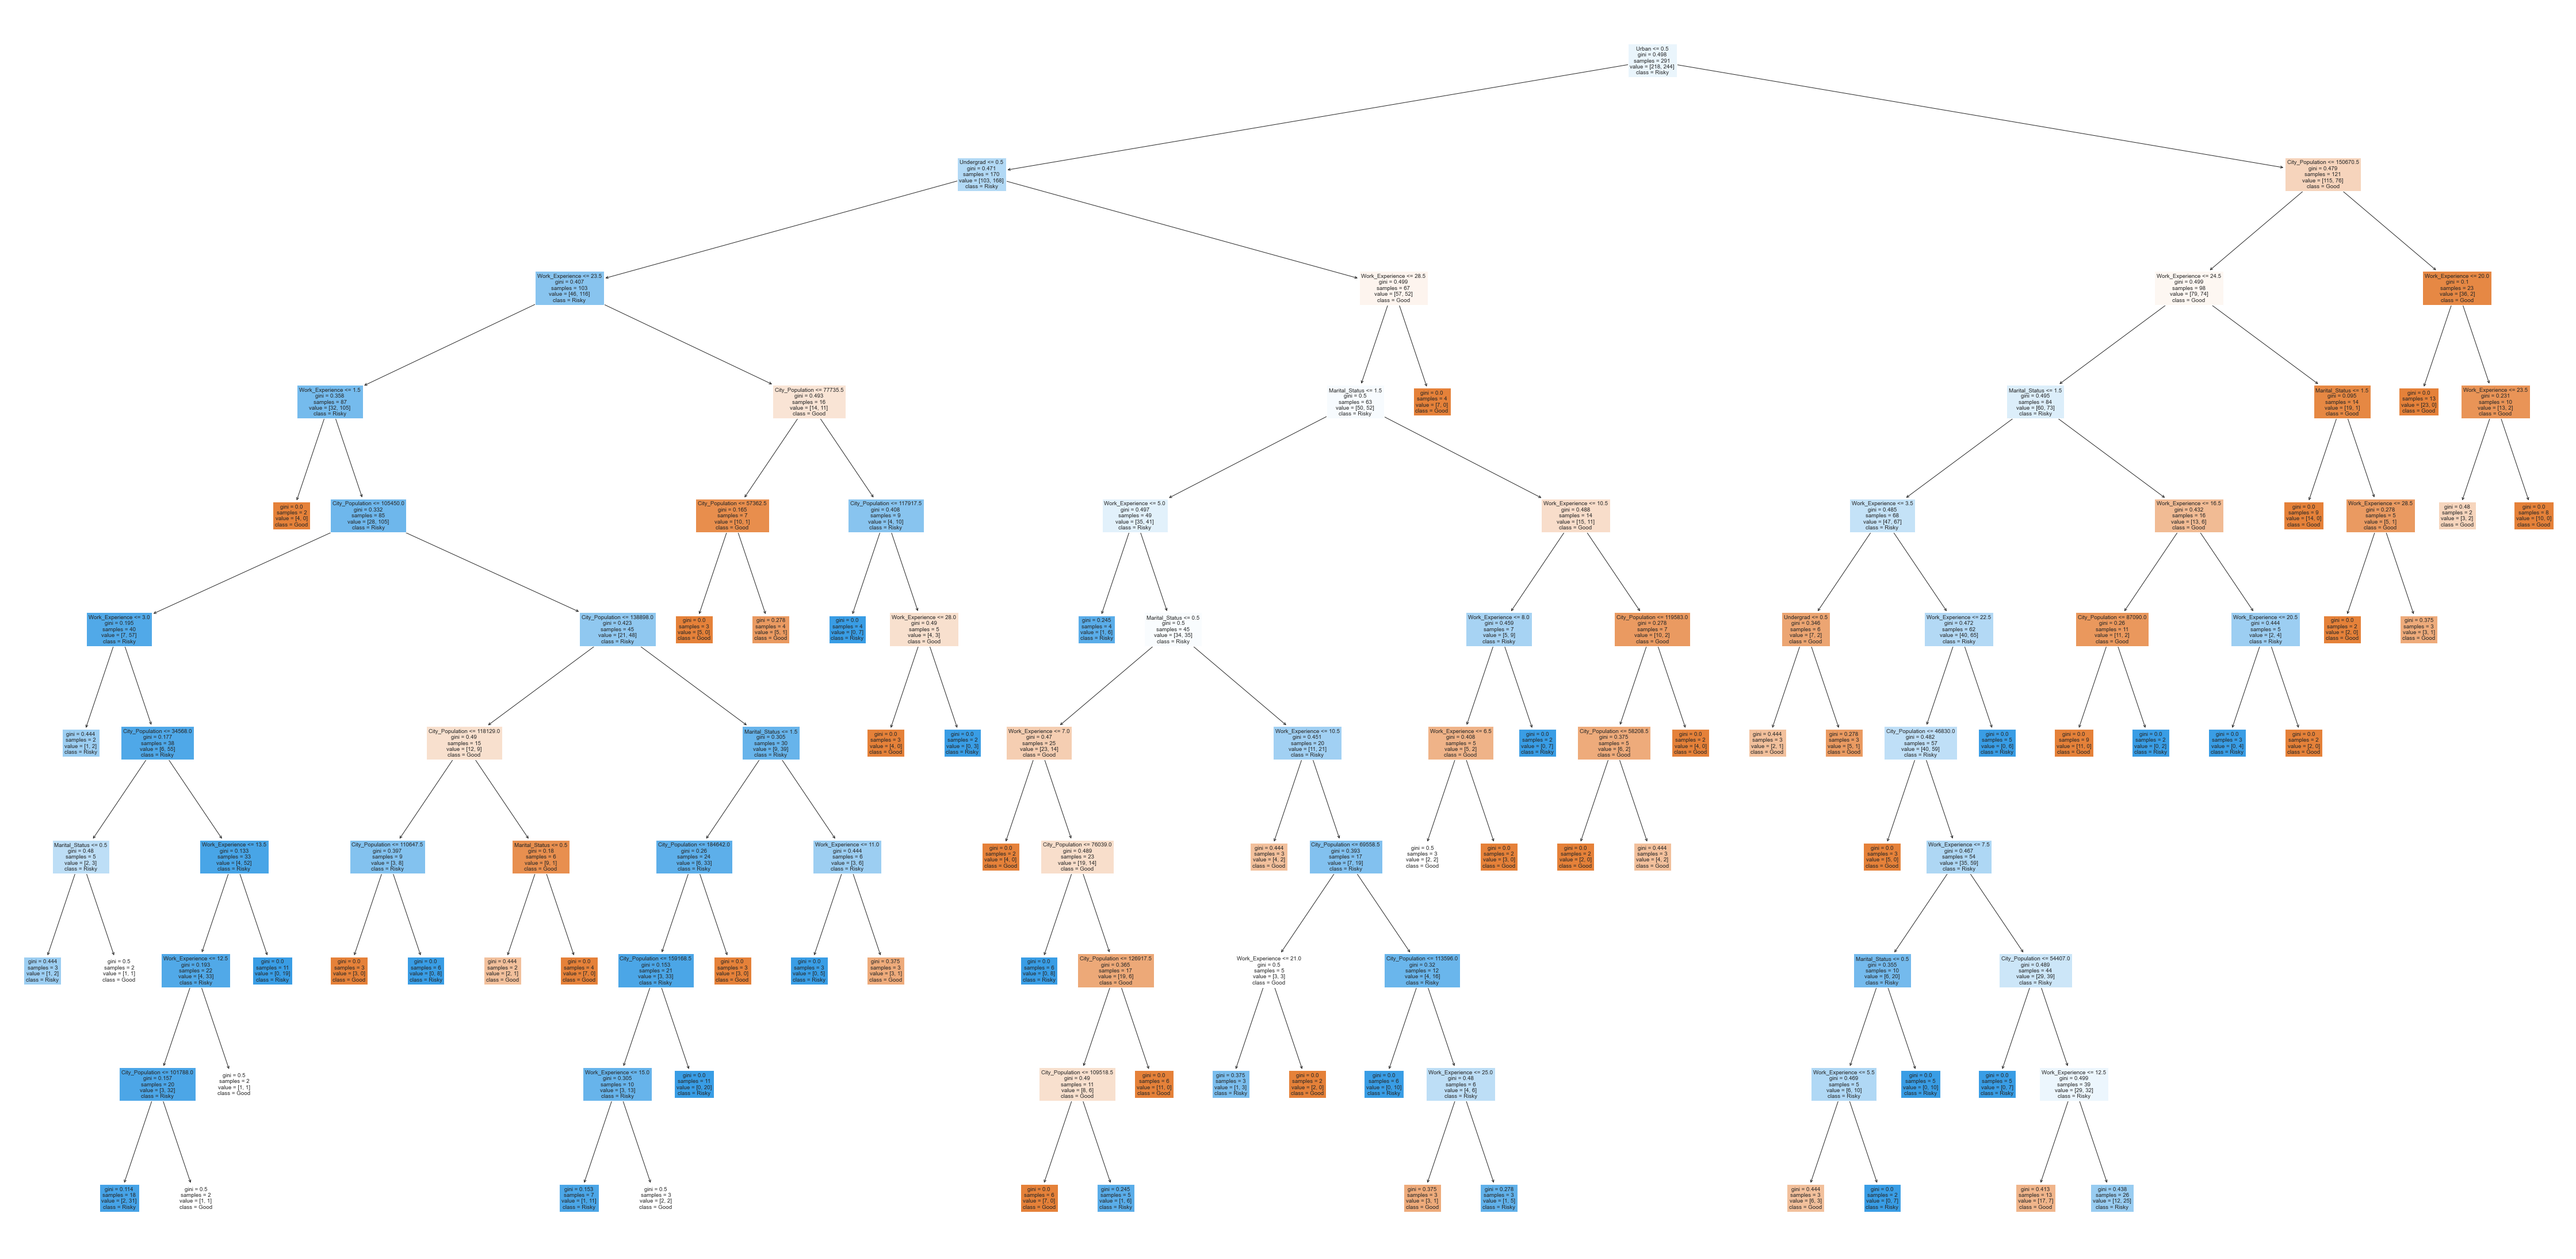

In [79]:
from sklearn.tree import plot_tree
plt.figure(figsize=(80,40))
plot_tree(rf_best.estimators_[59], feature_names = model_data.columns,class_names=df1.taxable_category.unique(),filled=True)
plt.show()

# Applications of Random Forest
## There are mainly four sectors where Random forest mostly used:
## Banking: Banking sector mostly uses this algorithm for the identification of loan risk.
## Medicine: With the help of this algorithm, disease trends and risks of the disease can be identified.
## Land Use: We can identify the areas of similar land use by this algorithm.
## Marketing: Marketing trends can be identified using this algorithm.
# Advantages of Random Forest
## 1. It can be used in classification and regression problems.
## 2. It solves the problem of overfitting as output is based on majority voting or averaging.
## 3. It performs well even if the data contains null/missing values.
## 4. Each decision tree created is independent of the other thus it shows the property of parallelization.
## 5. It maintains diversity as all the attributes are not considered while making each decision tree though it is not true in all cases.
## 6. It is immune to the curse of dimensionality. Since each tree does not consider all the attributes, feature space is reduced.
# Disadvantages of Random Forest
## 1. Random forest is highly complex when compared to decision trees where decisions can be made by following the path of the tree.
## 2. Training time is more compared to other models due to its complexity. Whenever it has to make a prediction each decision tree has to generate output for the given input data.
## 3. Although random forest can be used for both classification and regression tasks, it is not more suitable for Regression tasks.